# Federated Learning On Distributed Private Health Data On Smartphones

The **smartphones of the people probably carry the most valueable but also private data**. Since using data promisses to be one of the best ways to fight back against COVID-19, it is highly desirable to get access.


By using a **[Federated Learning](https://federated.withgoogle.com/)** approach with PySyft it is possible to **learn from the private data right on the smartphone, with the data never leaving the device**.


# Approach

1. Since there is no private dataset with health data during a virus outbreak, a **simulated dataset has been used to show the prove of concept**.
2. The **dataset contains the health status of each person** (e.g. temperature, movement, ... ) for several days during the virus outbreak.
3. Using PySyft-Workers the **data for each single person is distributed to a worker** (virtual smartphone). Therefor each worker only knows its own health status.
4. A **simple feedforward network is send to each worker during the training process**. The learning takes place directly on the virtual smartphone itself and an updated network is returned to the host. This way the data did never leave the smartphone and stays protected. 
5. The **target variable to predict is the total number of infected people** in this notebook.

# Conclusion

It is **possible to make us of the private health data of the people without lowering the protection of the data**.  
The notebook can be seen as prove of concept that learning on distributed individual health data can start a learning process in neural network. 


# Limitations (With Possible Solutions)

**Limitation:**  
Simulated data without a connection to the real world has been used.  
**Solution:**  
Exchanging the dataset and adjusting the code should be pretty easy.


**Limitation:**  
A trusted App with permission to store private health data on the device is needed on many smartphones.  
**Solution:**  
Probably another team created a similar App during the hackathon or there is an existing one already out there. Merging this approach with such an App is necessary. 


**Limitation:**  
The hardware limitations have been very strict for this notebook.  
**Solution:**  
Running the simulation and training process on a much larger scale should indicate if the approach is promising.



# 1. Import Libraries

In [1]:
# To comunicate with decentralised devices
import syft as sy

# To do linear algebra
import numpy as np

# To store data
import pandas as pd

# To get progression bars
from tqdm import tqdm

# To create neural networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# To create plots
import matplotlib.pyplot as plt

# To transform the input data
from torchvision import transforms

# To standardize the dataset
from sklearn.preprocessing import StandardScaler

# 2. Setup Variables, Functions And Classes

In [2]:
# Arguments for learning process
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 1000
        self.save_model = False

args = Arguments()

# Use CUDA
use_cuda = not args.no_cuda and torch.cuda.is_available()

# Set seed for computation
torch.manual_seed(args.seed)

# Create CUDA device
device = torch.device("cuda" if use_cuda else "cpu")

# Additional arguments for CUDA
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


# Define neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. Load And Prepare The Data

In [3]:
########## Create Training Dataset ##########
# Load the training data
df_train = pd.read_csv('data/Trainingset_Simulated_Virus_Outbreak.csv')

# Get number of toal infected people per day as prediction label
total_infected = df_train.groupby('Day')['Infected'].sum()

# Add the target column
df_train['Target'] = df_train['Day'].apply(lambda x: total_infected.loc[x])

# Transform the regression target 
df_train['Target'] = df_train['Target'].apply(np.log10)

# Transform the data with a standard scaler
sc = StandardScaler()
df_train[['Temperature', 'Distance']] = sc.fit_transform(df_train[['Temperature', 'Distance']])




########## Create Testing Dataset ##########
# Load the testing data
df_test = pd.read_csv('data/Testingset_Simulated_Virus_Outbreak.csv')

# Get number of toal infected people per day as prediction label
total_infected = df_test.groupby('Day')['Infected'].sum()

# Add the target column
df_test['Target'] = df_test['Day'].apply(lambda x: total_infected.loc[x])

# Transform the regression target 
df_test['Target'] = df_test['Target'].apply(np.log10)

# Transform the data with a standard scaler
df_test[['Temperature', 'Distance']] = sc.transform(df_test[['Temperature', 'Distance']])

df_test.sample(3)

,Day,Node,Infected,Immune,Temperature,Distance,Cough,Target
159884,15,9884,False,True,-0.425322,0.482921,False,3.693991
9981,0,9981,False,False,0.053389,0.356322,False,0.000000
155190,15,5190,False,True,-0.107030,-0.756200,False,3.693991


# 4. Start The Workers And Distribute The Datasets

In [4]:
# Create a hook to devices
hook = sy.TorchHook(torch)

# Transforms for the data
transform = transforms.ToTensor()



########## Create Training Workers And Dataset ##########
# Number of nodes (Fewer nodes are used since hardware restrictions; all nodes would be optimal)
n = 500 # df['Node'].nunique()

# Create a virtual training worker for each simulated device
training_workers = [sy.VirtualWorker(hook, id=node) for node in range(n)]


# Store all distributed datasets
datasets_train = []
datasets_test = []

# Iterate over all training workers
for i, worker in tqdm(enumerate(training_workers)):
    
    # Filter for the workers specific training dataset
    y = df_train[df_train['Node']==i]['Target'].values
    X = df_train[df_train['Node']==i].drop(['Day', 'Node', 'Target'], axis=1).values

    # Transform data to tensors
    y = torch.tensor(y)
    X = torch.tensor([values.astype(float) for values in X])
    
    # Store the dataset
    datasets_train.append(sy.BaseDataset(X, y, transform=transform).send(worker))
    
    
    # Filter for the workers specific testing dataset
    y = df_test[df_test['Node']==i]['Target'].values
    X = df_test[df_test['Node']==i].drop(['Day', 'Node', 'Target'], axis=1).values

    # Transform data to tensors
    y = torch.tensor(y)
    X = torch.tensor([values.astype(float) for values in X])
    
    # Store the dataset
    datasets_test.append(sy.BaseDataset(X, y, transform=transform).send(worker))



# Create a federated dataset
dataset_train_federated = sy.FederatedDataset(datasets_train)

# Create a federated loader
dataloader_train_federated = sy.FederatedDataLoader(dataset_train_federated, shuffle=True, batch_size=10)


# Create a federated dataset
dataset_test_federated = sy.FederatedDataset(datasets_test)

# Create a federated loader
dataloader_test_federated = sy.FederatedDataLoader(dataset_test_federated, shuffle=True, batch_size=10)

AttributeError: module 'syft' has no attribute 'TorchHook'

# 5. Start Training

In [ ]:
# Define training process
def train(args, model, device, federated_train_loader, optimizer, epoch):
    
    # Accumulate total loss
    total_loss = []
    
    # 
    model.train()
    
    # Iterate over the federated training datasets
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        
        # Send the model to the worker of the training batch
        model.send(data.location)
        
        # Move the training tensors to CUDA device
        data, target = data.to(device), target.to(device)
        
        # Set the gradients to zero
        optimizer.zero_grad()
        
        # Pass the data through the model
        output = model(data.float())
        
        # Compute the training loss
        #loss = nn.MSELoss(output, target.long())
        loss = nn.MSELoss()(output, target.float())
        
        # Backpropagate the loss through the network
        loss.backward()
        
        # Perform an update of the network
        optimizer.step()
        
        # Return the model
        model.get()
        
        # Return the loss
        loss = loss.get()
        total_loss.append(loss)
        
        # Check to create new log entry (Stopped printing for github)
        if batch_idx % args.log_interval == 0 or False:
            
            # Update training process
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
                                                                           batch_idx * args.batch_size, 
                                                                           len(federated_train_loader) * args.batch_size,
                                                                           100. * batch_idx / len(federated_train_loader), 
                                                                           loss.item()))
        
    # Retrieve data from tensors
    total_loss = [tensor.cpu().data.numpy() for tensor in total_loss]
    
    # Return mean loss per batch
    mean_loss = np.mean(total_loss) 
    
    # Display mean loss per batch
    print('Train Mean Batch Loss: {}'.format(mean_loss))
    return mean_loss





# Define testing process
def test(args, model, device, federated_test_loader):
    
    # Accumulate total loss
    total_loss = []
    
    # Iterate over the federated training datasets
    for batch_idx, (data, target) in enumerate(federated_test_loader):
        
        # Send the model to the worker of the testing batch
        model.send(data.location)
        
        # Move the testing tensors to CUDA device
        data, target = data.to(device), target.to(device)
        
        # Pass the data through the model
        output = model(data.float())
        
        # Compute and store the testing loss
        loss = nn.MSELoss()(output, target.float())
        total_loss.append(loss.get())
        
        # Return the model
        model.get()
    
    
    # Retrieve data from tensors
    total_loss = [tensor.cpu().data.numpy() for tensor in total_loss]
    
    # Return mean loss per batch
    mean_loss = np.mean(total_loss) 
    
    # Display mean loss per batch
    print('Test Mean Batch Loss: {}\n'.format(mean_loss))
    return mean_loss

In [ ]:
%%time

# Create the neural network
model = Net().to(device)

# Create an optimizer for the network
optimizer = optim.SGD(model.parameters(), lr=args.lr)


# Store losses for training inspection
training_losses = []
testing_losses = []

# Iterate over all epochs
for epoch in range(1, args.epochs + 1):
    
    # Perform the training
    mean_training_loss = train(args, model, device, dataloader_train_federated, optimizer, epoch)
    
    # Perform the testing
    mean_testing_loss = test(args, model, device, dataloader_test_federated)
    
    # Store losses
    training_losses.append(mean_training_loss)
    testing_losses.append(mean_testing_loss)

/home/morris/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:346: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  response = command_method(*args, **kwargs)


Train Epoch: 1 [0/160000 (0%)]	Loss: 11.183391
Train Epoch: 1 [64000/160000 (40%)]	Loss: 0.956630
Train Epoch: 1 [128000/160000 (80%)]	Loss: 0.484454
Train Mean Batch Loss: 0.9100412130355835
Test Mean Batch Loss: 0.7059358954429626

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.322337
Train Epoch: 2 [64000/160000 (40%)]	Loss: 0.678651
Train Epoch: 2 [128000/160000 (80%)]	Loss: 1.059578
Train Mean Batch Loss: 0.869154691696167
Test Mean Batch Loss: 0.7043458223342896

Train Epoch: 3 [0/160000 (0%)]	Loss: 0.279500
Train Epoch: 3 [64000/160000 (40%)]	Loss: 1.143875
Train Epoch: 3 [128000/160000 (80%)]	Loss: 0.347220
Train Mean Batch Loss: 0.8682422637939453
Test Mean Batch Loss: 0.7029758095741272

Train Epoch: 4 [0/160000 (0%)]	Loss: 1.041262
Train Epoch: 4 [64000/160000 (40%)]	Loss: 1.411778
Train Epoch: 4 [128000/160000 (80%)]	Loss: 1.416463
Train Mean Batch Loss: 0.8672056794166565
Test Mean Batch Loss: 0.702741801738739

Train Epoch: 5 [0/160000 (0%)]	Loss: 1.121305
Train Epoch: 5 [64000/1

# 6. Inspect Training Process

NameError: name 'training_losses' is not defined

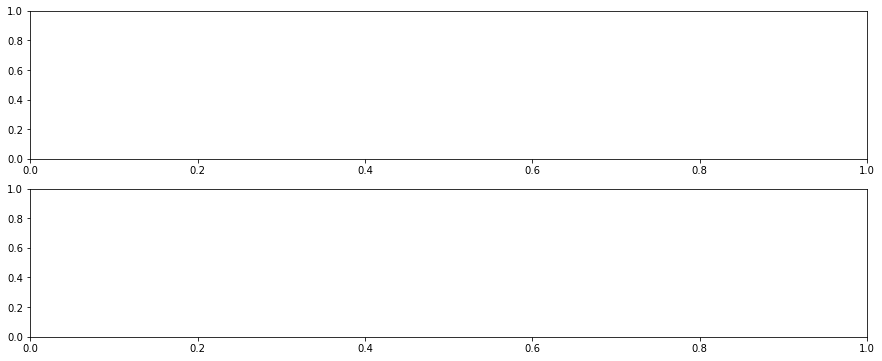

In [ ]:
# Create a plot for training inspection
fig, axs = plt.subplots(2, figsize=(15, 6))

# Training losses
axs[0].plot(range(len(training_losses)), training_losses)
axs[0].set_title('Training Losses')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')

# Testing losses
axs[1].plot(range(len(testing_losses)), testing_losses)
axs[1].set_title('Testing Losses')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MSE')

plt.tight_layout()
plt.savefig('build/Inspecting_Training_Process.png')
plt.show()